# Introduction

## Overview

This is a variation of [the original Analysis notebook](https://github.com/kamfonas/squadBERT/blob/main/notebooks/Analysis_v1.ipynb) with added functionality to exploit json files produced after validation or testing. 

Our premise, as described in more detail in the Analysis notebook, is that in addition to using exact match or F1 scores, measuring the proximity to the top prediction of the correct answer, provides useful insight into the progress of learning, hyperparameter tuning, or the comparison of models and architectures. 

We initially adopt the formatting proposed by Huggingface since their hub includes a large collection of architectures and models for the QA task. At the end of validation or test runs, a post-processing function yields a json file with the N-best answers for each example. Using N=20, for example, we can  extract the top 20 predictions for each example tested. Since we know the top 4 answers for every example from the golden dataset, we can try to match them in the top 20-list, and rank or score the proximity of the correct answers to highest confidence predictdion. 

This notebook demonstrates how we can pair the golden answers to our top-N predictions and calculates various metrics that measure proximity or rank of the correct answer.

## Postprocessing and Metrics 
We follow the postprocessing of the question-answering model output from logits to the computation of exact match (EM) and F1 metrics. 
These metrics deal with the top prediction. When this prediction is incorrect, it is common that a golden answer matches some other one of the top-N predictions. We look for a statistic that quantifies the proximity of the golden aswer in the top-N prediction pecking order of the evaluation set. We use the discounted rank of the prediction that matches the golden answer, so that the further down the order of predictions the lower the contribution of a correct match.  

## From Logits to Predictions
We assume that our evaluation set contains $M$ question-answer examples with varying context length $N^{(i)}$ measured in word tokens. For each example $i \in [1,M]$ the output layer of the model returns a start and an end prediction vector of logit values $\hat{y}^{S(i)}_j$  and $\hat{y}^{E(i)}_j$ where $j \in [1,N^{(i)}]$. These two logit vectors are treated as estimations of the *log of the odds* that the token in position $j$ marks the start or end token position of the answer segment respectively. By passing these logit vectors through a softmax function, the log of the odds is converted to prediction probability distribution vectors, $\hat{p}_j^{S(i)}$ and $\hat{p}_j^{E(i)}$ of the same shape as the logits.  

 In a perfect world, we should be able to use the highest probability start and end indexes to identify the highest probability answer prediction. 
    $$S^{(i)}=\underset{j\in [1,N]}{\arg\max}\,(\hat{p}_j^{S(i)})$$
    $$E^{(i)}=\underset{j\in[1,N]}{\arg\max}\,(\hat{p}_j^{E(i)})$$
The best answer prediction is the span of the context that starts at position $S^{(i)}$ and ends at $E^{(i)}$.   
 In the real world these answer spans may be invalid. For example, the end-position may precede the start-position or the  span length may exceed the allowed threshold or either of the positions may be out of bounds. These situations can be checked and controlled by constraints or other strategies that are implementation dependent. Such a strategy is to avoid the out-of-bounds constraint by properly masking the token sequence before applying the softmax. 
 
 Since some spans may be invalid, we need a strategy to choose the next best prediction span if the top choice is invalid. Should we try the next best end or maybe the next start or skip to the next pair? Or should we consider the question unanswerable? Instead of dealing with two independent probability distributions for the starts and ends it would be better to have a function that generates an ordered list of answers and their corresponding probabilities. This list could theoretically include all possible spans, but in practice a handful of them would be enough. In our tests, we use the  Huggingface framework which uses such a method.

Visualize a weight matrix of all possible combinations of start (rows) and end (columns): $\bf{\hat{w}}^{(i)} \in \mathcal{R}^{N^{(i)} \times N^{(i)}}$. Each cell of the matrix represents a possible span, and the value denotes the rank from most probable to least probable answer prediction. Cells denoting invalid spans should have zero-weight. For example, all elements below the diagonal that denote ends before starts should be zero, or outside the band where the answer span length exceeds a given threshold would also be set to zero. The rest of the valid cells will be assigned a computed probability (or weight) that reflects our chosen prioritization scheme. We need a function that checks span validity and combines start and end probabilities to produce a single value for each candidate span. The following are some of these choices:

### Product:
   The favored combinations are those which have both start and end probabilities high. A near-zero end probability penalizes the combination:
   $$w^{SE}=p^S p^E$$

### Harmonic Mean:
   This is a variation of the product method:
   $$w^{SE}=\frac{2 p^S p^E}{p^S + p^E}$$

### Average:
   The average probability of start and end is what we used in our evaluation. 
   $$w^{SE}=\frac{p^S + p^E}{2}$$

### Weighted Average:
   The idea here is to place more emphasis on the probability of the starting token than the ending token. 
   $$w^{SE}=\frac{w^S p^S + w^E p^E}{w^S+w^E}$$

   Weighing the start twice as much as the end is proposed [here](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf)

The cells of the matrix can be ordered with the top choice being the prediction. We use the top-N choices out of this matrix to support a statistic that measures the proximity of the golden answer to the top prediction.  

In practice, it is more efficient to reduce the matrix to the top-ranking starts and ends and avoid the cost of building the whole matrix. It would be interesting to study how each of these methods affect the prediction and the impact on performance. We have not been able to identify such a study although researchers do consider and try such alternatives in optimizing their models. 


In [1]:
#https://stackoverflow.com/questions/63329657/python-3-7-error-unsupported-pickle-protocol-5
#import pickle5 as pickle
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import seaborn as sns
import urllib
#import wget
from utils_anal import *
#rename things that arent logs later
import os
from pathlib import Path
import json
from collections import Counter
import datetime
import datasets
from datasets import ClassLabel, Sequence, load_dataset, load_metric
import random
import pandas as pd
from IPython.display import display, HTML
import datetime
import string
import re
from statistics import  median_grouped
from tqdm import tqdm


/home/farsipal/miniconda3/envs/nlu3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def download_url(url, output_path, show_progress=True):
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)

    if show_progress:
        # Download with a progress bar
        with DownloadProgressBar(unit='B', unit_scale=True,
                                 miniters=1, desc=url.split('/')[-1]) as t:
            urllib.request.urlretrieve(url,
                                       filename=output_path,
                                       reporthook=t.update_to)
    else:
        # Simple download with no progress bar
        urllib.request.urlretrieve(url, output_path)

stanford_squad2_dev_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json"
save_stanford_squad2 = "stanford_squad2_dev.json"
download_url(stanford_squad2_dev_url,save_stanford_squad2)

dev-v2.0.json: 4.37MB [00:00, 5.39MB/s]                            



## Load the SQuAD Dataset

We now download the squad_v2 dataset from the hub. We will use it to get the golden answers so that we can calculate performance metrics. The dataset class has a method for loading the dataset from the huggingface hub or from a disk location. The loaded object belongs to that class



In [3]:
dataset_name = "squad_v2"
#dataset_name = "squad"

raw_datasets = load_dataset(dataset_name)
print('The raw dataset dictionary contains two datasets of type %s:' % (type(raw_datasets["validation"])))
raw_datasets

#['num_rows']


Reusing dataset squad_v2 (/home/farsipal/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)
100%|██████████| 2/2 [00:00<00:00, 533.56it/s]

The raw dataset dictionary contains two datasets of type <class 'datasets.arrow_dataset.Dataset'>:


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

The following function allows us to inspect the contents of the downloaded data. Every time the function is invoked it prduces a new set of random selections.

Every time you execute this function it will generate new samples. Use it to find IDs you want to use for testing.

In [4]:
show_random_elements(raw_datasets["validation"])

,id,title,context,question,answers
0,5729e2b76aef0514001550d2,Economic_inequality,"During the mass high school education movement from 1910–1940, there was an increase in skilled workers, which led to a decrease in the price of skilled labor. High school education during the period was designed to equip students with necessary skill sets to be able to perform at work. In fact, it differs from the present high school education, which is regarded as a stepping-stone to acquire college and advanced degrees. This decrease in wages caused a period of compression and decreased inequality between skilled and unskilled workers. Education is very important for the growth of the economy, however educational inequality in gender also influence towards the economy. Lagerlof and Galor stated that gender inequality in education can result to low economic growth, and continued gender inequality in education, thus creating a poverty trap. It is suggested that a large gap in male and female education may indicate backwardness and so may be associated with lower economic growth, which can explain why there is economic inequality between countries.",What can result in creating a poverty trap?,"{'text': ['gender inequality in education', 'low economic growth', 'continued gender inequality in education'], 'answer_start': [712, 757, 782]}"
1,572ff12e04bcaa1900d76f00,Rhine,"Between Bingen and Bonn, the Middle Rhine flows through the Rhine Gorge, a formation which was created by erosion. The rate of erosion equaled the uplift in the region, such that the river was left at about its original level while the surrounding lands raised. The gorge is quite deep and is the stretch of the river which is known for its many castles and vineyards. It is a UNESCO World Heritage Site (2002) and known as ""the Romantic Rhine"", with more than 40 castles and fortresses from the Middle Ages and many quaint and lovely country villages.",Where does the Middle Rhine flow between Bingen and Bonn?,"{'text': ['Rhine Gorge', 'Rhine Gorge', 'Rhine Gorge'], 'answer_start': [60, 60, 60]}"
2,5ad02ef677cf76001a686d68,Imperialism,"Along with advancements in communication, Europe also continued to advance in military technology. European chemists made deadly explosives that could be used in combat, and with innovations in machinery they were able to manufacture improved firearms. By the 1880s, the machine gun had become an effective battlefield weapon. This technology gave European armies an advantage over their opponents, as armies in less-developed countries were still fighting with arrows, swords, and leather shields (e.g. the Zulus in Southern Africa during the Anglo-Zulu War of 1879).",What advancements besides military technology did Europe not achieve?,"{'text': [], 'answer_start': []}"


We are interested in the validation dataset. Here is its type:

In [5]:
type(raw_datasets["validation"])

datasets.arrow_dataset.Dataset

## Index by ID


In order to be able to match the entries of the original dataset with those of our prediction, we need to map each ID to the respective row number of the validation raw dataset. We construct an index, as a dictionary, keyed on the ID from the validataion raw dataset and pointing to the corresponding row-number of the validation dataset.

In [6]:
ix_id = dict([(x['id'],i) for i,x in enumerate(raw_datasets['validation'])])

Now, we can use this index to get to the golden answer for a given id. This mapping is repeated inside the class defined in the next section below. 



# The ResultSet Class

## Class Overview


To facilitate management and data collection we build a dictionary of available data sources derived from runs logged under a user-provided root directory (saveRoot.)

The SaveRoot descendent directories are searched for all instances of a fiile named *eval_nbest_predictions.json*. Every directory containing this file is a potential source for N-best predictions. We load the ones that satisfy these additional conditions:

1.  if a *config.json* file exists in the same directory
2.  If a file named *all_results.json* exists in the same directory

These files are written by the training/evaluation process after successful completion of a run. 

The function **get_resultsets_from_root(saveRoot)** performs the above steps and returns a directory with the following information:

<dl>
<dt><b>mtime</b></dt>
    <dd>The last modification time of the eval_nbest_predictions.json file</dd>
<dt><b>config</b></dt>
    <dd>Model configuration of used to produce the top-N results</dd>
<dt><b>all_results</b></dt>
    <dd>The results of the last run that produced the top-N results</dd>
<dt><b>topN</b></dt>
    <dd>A dictionary keyed on the ID of each question pointing to an ordered N-long list in descending order of probability with the predicted details. These details are organized as dictionaries containing:
    </ul>
    <li><b>start logit</b></li>
    <li><b>end logit</b></li>
    <li><b>answer text</b></li>
    <li><b>probability</b></li>
    </ul>
    </dd>
<dt><b>null odds</b></dt>
    <dd>The odds determining the likelihood that this is a no-answer question for each example</dd>
</dl>

We augment our **prediction** dictionary to include the **id** as a field, the **rank** of each predicted answer (with values from 0 to N), and the gold answers (**goldenAnswers**), which is a list containing the distinct text of the answers found in the SQuAD_V2 dataset. Finally, we also include an indicator showing whether the prediction is the **correct** answer.

The **contextLen** field denotes the original number of characters in the context field. This can be used for normalization when comparing probabilities of different size contexts. A more appropriate length would be the number of tokens or number of words in the context.  

Notice that to indicate no answer, the prediction text is an empty string while the goden answer is an empty list. 

The class, when initialized with a root directory, searches all its subdirectories to find top-N prediction output files. It also accepts an original examples dataset which was used as input to our training/evaluation script. From these two pieces of information, the class materializes a number of dictionaries and carries methods for data extraction and generating all necessary values for visualizations. 

Method topNPredsDF takes an optional maxBins parameter that sets a limit to the rank values. The function returns a pandas dataframe that contains the following columns:
    <ul>
    <li><b>start logit</b></li>
    <li><b>end logit</b></li>
    <li><b>answer text</b></li>
    <li><b>probability</b> derived from the combination of start and end probabilities</li>
    <li><b>experiment</b> derived from the output directory path</li>
    <li><b>example id</b></li>
    <li><b>rank</b> in descending order of probability for as many available ranks are available in the logs.
    <li><b>bins</b> this is driven by the topK parameter and is assigned the rank value up to the maxBins parameter. This is a convenient way to throttle very long top-N lists to a desired max size for plotting purposes. All the rows that exceed the rank are still available, but the rank number is the same maximum value (defaults to 20)</li>
    <li><b>correct</b> is True if it matches one of the golden answers using the exact match logic (EM) regardless of rank</li>
    <li><b>contextLen</b> in characters</li>
    </ul>



## Create a Class Instance and List Summary Info 

In [7]:
RS = ResultSet("../save-models/squad_v2",raw_datasets["validation"])


In [8]:
RS.summaryDF()


,experiment,mtime,example_count,topK
0,/bert-base-uncased/001,2021-08-18T10:46:51,11873,10
1,/bert-base-uncased/007,2021-08-19T03:49:13,11873,10
2,/bert-base-uncased/009,2021-08-26T10:57:47,11873,100
3,/bert-base-uncased/010,2021-09-11T11:28:41,11873,10
4,/bert-large-cased-whole-word-masking/003,2021-08-24T21:11:13,11873,10
5,/deepset/bert-large-uncased-whole-word-masking...,2021-09-03T18:03:23,11873,10
6,/mrm8488/longformer-base-4096-finetuned-squadv...,2021-08-22T16:27:11,11873,10
7,/mrm8488/longformer-base-4096-finetuned-squadv...,2021-09-03T17:45:31,11873,10
8,/navteca/electra-base-squad2/005,2021-08-17T12:50:17,11873,10
9,/navteca/electra-base-squad2/006,2021-08-20T15:27:11,11873,10


In [9]:

with open('../assets/experSummary.tex','w') as F:
    F.write(RS.summaryDF().to_latex())

/tmp/ipykernel_38670/1784640462.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(RS.summaryDF().to_latex())


In [10]:
RS.experiments

['/bert-base-uncased/001',
 '/bert-base-uncased/007',
 '/bert-base-uncased/009',
 '/bert-base-uncased/010',
 '/bert-large-cased-whole-word-masking/003',
 '/deepset/bert-large-uncased-whole-word-masking-squad2/001',
 '/mrm8488/longformer-base-4096-finetuned-squadv2/009',
 '/mrm8488/longformer-base-4096-finetuned-squadv2/011',
 '/navteca/electra-base-squad2/005',
 '/navteca/electra-base-squad2/006',
 '/navteca/electra-base-squad2/007',
 '/navteca/roberta-base-squad2/001',
 '/navteca/roberta-base-squad2/002',
 '/twmkn9/distilbert-base-uncased-squad2/003',
 '/twmkn9/distilbert-base-uncased-squad2/004',
 '/twmkn9/distilbert-base-uncased-squad2/008']

The summary lists the name (derived from the directory structure) for each experiment captured in the class, followed by the last modification date, , the number of examples in the dataset, and the length of the top-K predictions recorded in the logs.


## Assign Labels to Experiments
We assign abbreviated labels for each experiment to keep legends small

In [11]:
short_labels = []
for exp in RS.experiments:
    nm1 = exp.split('/')
    nm0 = nm1[-2]
    #print(exp,str(namSplit2[0])+'/'+str(namSplit1[-1]))
    nm0 = re.sub('-base','',nm0)
    nm0 = re.sub('large','lg',nm0)
    nm0 = re.sub('uncased','uc',nm0)
    nm0 = re.sub('cased','cas',nm0)
    nm0 = re.sub('whole-word-masking','wwm',nm0)
    nm0 = re.sub('-finetuned','',nm0)
    nm0 = re.sub('-squad.*2','-sq2',nm0)
    nm0 = re.sub('-[0-9]{4}','',nm0)  
    short_labels.append(str(nm0+'/'+str(nm1[-1])))
RS.set_labels(short_labels)
RS.labels

['bert-uc/001',
 'bert-uc/007',
 'bert-uc/009',
 'bert-uc/010',
 'bert-lg-cas-wwm/003',
 'bert-lg-uc-wwm-sq2/001',
 'longformer-sq2/009',
 'longformer-sq2/011',
 'electra-sq2/005',
 'electra-sq2/006',
 'electra-sq2/007',
 'roberta-sq2/001',
 'roberta-sq2/002',
 'distilbert-uc-sq2/003',
 'distilbert-uc-sq2/004',
 'distilbert-uc-sq2/008']

In [12]:
abbrevLabel = {RS.experiments[i] : RS.labels[i] for i in range(len(RS.labels))}

## Looking-up Information for a Specific Example ID

In [13]:
RS.dataset[RS.ix_id['571c96095efbb31900334dc0']] 

{'id': '571c96095efbb31900334dc0',
 'title': 'Oxygen',
 'context': 'Oxygen is more soluble in water than nitrogen is. Water in equilibrium with air contains approximately 1 molecule of dissolved O\n2 for every 2 molecules of N\n2, compared to an atmospheric ratio of approximately 1:4. The solubility of oxygen in water is temperature-dependent, and about twice as much (14.6 mg·L−1) dissolves at 0 °C than at 20 °C (7.6 mg·L−1). At 25 °C and 1 standard atmosphere (101.3 kPa) of air, freshwater contains about 6.04 milliliters (mL) of oxygen per liter, whereas seawater contains about 4.95 mL per liter. At 5 °C the solubility increases to 9.0 mL (50% more than at 25 °C) per liter for water and 7.2 mL (45% more) per liter for sea water.',
 'question': 'How much more oxygen dissolves at 0 degrees C than at 20 degrees C?',
 'answers': {'text': ['twice',
   '50% more',
   'about twice as much',
   'twice as much',
   'twice'],
  'answer_start': [286, 579, 280, 286, 286]}}

In [14]:
RS.topNPreds()[0]['5728fc9e1d04691400778f15'][0:1]

[{'start_logit': 6.09079647064209,
  'end_logit': 5.010820388793945,
  'text': '',
  'probability': 0.999997615814209,
  'experiment': '/bert-base-uncased/001',
  'id': '5728fc9e1d04691400778f15',
  'rank': 0,
  'goldAns': ["the leaflets will have to be given to the leafleter's own jury as evidence",
   "if they arrest fully informed jury leafleters, the leaflets will have to be given to the leafleter's own jury as evidence"],
  'correct': False,
  'contextLen': 1453,
  'bin': 0}]

In [15]:
ids=['57263c78ec44d21400f3dc7c', '57267d52708984140094c7da', '5728dc2d3acd2414000e0080', '572742bd5951b619008f8787']
RS.dataset[RS.ix_id[ids[0]]] 

{'id': '57263c78ec44d21400f3dc7c',
 'title': 'Packet_switching',
 'context': 'ARPANET and SITA HLN became operational in 1969. Before the introduction of X.25 in 1973, about twenty different network technologies had been developed. Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core. In the datagram system, the hosts have the responsibility to ensure orderly delivery of packets. The User Datagram Protocol (UDP) is an example of a datagram protocol. In the virtual call system, the network guarantees sequenced delivery of data to the host. This results in a simpler host interface with less functionality than in the datagram model. The X.25 protocol suite uses this network type.',
 'question': '2 differences betwen X.25 and ARPNET CITA technologies ',
 'answers': {'text': ['Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the netwo

## Explore random example top-K predictions
But first, let's explore the data dictionary we assembled and look at a three random examples. 

1.  We first select **num_examples** (default to 3) numbers in the range of all the keys of the data dictionary
2.  Look up the keys that appear at these three sequencial positions in the sequence of all keys
3.  Get the values pointed to by those keys
4.  Build a data frame by traversing the list of each of the chosen values and extracting the field names and fields.
5.  Finally display the rank, predicted answer text,  golden answer list,  probability used to rank this choice, and whether this is a correct prediction. 

Every time the command is issued new random samples are displayed. 

In [16]:
DF = RS.show_random_qa_predictions(3,num_examples = 2, verbose = False)
DF


,id,rank,text,goldAns,probability,correct
0,57263677ec44d21400f3dc4a,0,"a general architecture for a large-scale, dist...","[a general architecture for a large-scale, dis...",5.102975e-01,True
1,57263677ec44d21400f3dc4a,1,described a general architecture for a large-s...,"[a general architecture for a large-scale, dis...",1.462822e-01,False
2,57263677ec44d21400f3dc4a,2,"a general architecture for a large-scale, dist...","[a general architecture for a large-scale, dis...",1.123820e-01,True
3,57263677ec44d21400f3dc4a,3,"general architecture for a large-scale, distri...","[a general architecture for a large-scale, dis...",1.037197e-01,True
4,57263677ec44d21400f3dc4a,4,Report P-2626 described a general architecture...,"[a general architecture for a large-scale, dis...",4.688153e-02,False
5,57263677ec44d21400f3dc4a,5,described a general architecture for a large-s...,"[a general architecture for a large-scale, dis...",3.221548e-02,False
6,57263677ec44d21400f3dc4a,6,"general architecture for a large-scale, distri...","[a general architecture for a large-scale, dis...",2.284202e-02,True
7,57263677ec44d21400f3dc4a,7,Report P-2626 described a general architecture...,"[a general architecture for a large-scale, dis...",1.032464e-02,False
8,57263677ec44d21400f3dc4a,8,a general architecture,"[a general architecture for a large-scale, dis...",9.965958e-03,False
9,57263677ec44d21400f3dc4a,9,"large-scale, distributed, survivable communica...","[a general architecture for a large-scale, dis...",5.071492e-03,False


We can save a latex version of the output

In [17]:
with open('../assets/randomtopKpredictions2.tex','w') as F:
    F.write(DF.to_latex())

/tmp/ipykernel_38670/1804491772.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(DF.to_latex())


# EM and F1 Evaluation Metircs

These are extracted from the reported validation metrics for each experiment. They include exact match (EM) and F1 scores for the questions with answers and those with no answers separately, as well as all of them in total. Notice that there is no distinction between exact match and F1 for no-answer questions. 

In [18]:
RS.eval_metrics()

,EM_ans,F1_ans,F1-EM_ans_delta,noans,EM,F1,F1-EM_delta
0,70.951417,78.934411,7.982994,71.572750,71.262528,75.248310,3.985782
1,69.129555,76.915674,7.786119,77.022708,73.081782,76.969268,3.887485
2,68.522267,75.441761,6.919494,77.527334,73.031247,76.486041,3.454793
3,67.594467,74.788812,7.194345,77.443230,72.525899,76.117921,3.592022
4,76.180837,82.230080,6.049243,85.264929,80.729386,83.749677,3.020291
5,79.487179,85.444250,5.957071,82.321278,80.906258,83.880528,2.974271
6,75.033738,82.738118,7.704380,82.910008,78.977512,82.824186,3.846674
7,78.677463,85.534793,6.857330,81.126997,79.903984,83.327740,3.423756
8,77.918354,85.303190,7.384836,77.022708,77.469890,81.157021,3.687131
9,77.378543,85.117483,7.738940,81.328848,79.356523,83.220453,3.863930


## F1 is highly correlated with Exact Match
The following plot uses the data above to demonstrate the high correlation between EM and F1 scores.

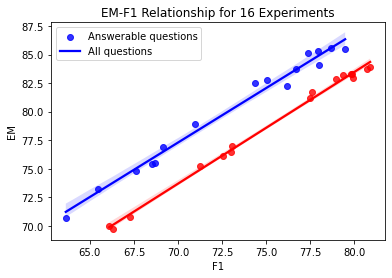

In [19]:
import seaborn as sns

X = RS.eval_metrics()

#create scatterplot with regression line
sns.regplot(x='EM_ans',y='F1_ans',color='blue',data=X)
sns.regplot(x='EM',y='F1',color='red',data=X)

#plt.scatter(X.EM_ans,X.F1_ans,color='blue')
#plt.scatter(X.noans,X.noans,color='green')
#plt.scatter(X.EM,X.F1,color='red')

plt.title("EM-F1 Relationship for %i Experiments" % len(X))
plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('F1')
plt.ylabel('EM')
plt.savefig('../assets/EM_F1_correlation.png',dpi=300)

# Golden Prediction Rank

## Definition

The Golden Prediction Rank, or simply Golden Rank (GR)  is defined as the rank of the highest probability prediction that exactly matches one of the answers. Operationally, this is better visualized following these steps:

1.  Assume an ordered list from highest to lowest probability of all valid spans of the context of a given example
2.  Starting from the top, in descending probability order, try each of the spans and identify the first one that contains an exact match to any of the golden answers
3.  The rank of that element is the golden prediction rank (GR) for that example


## Top-10 GRs Fine-Tuned Model Eval Runs

These include all evaluations using models that we did not fine-tune or train, but downloaded them already fine-tuned on SQuAD v2.

We first extract the top-K ranking predictions for each experiment. 

In [20]:
grls_np, nas_np, maxBins, medians, grls = RS.calc_golden_ranks(maxBins = 10,experimentIdx=None)

We can now plot the topN golden predictions by rank. We superimpose the medians of ranks > 0.

In [21]:
L = [i for i in range(len(RS.labels)) if 'eval' in RS.labels[i]]
L_eval = [5,7,10,12,15]
L = L_eval

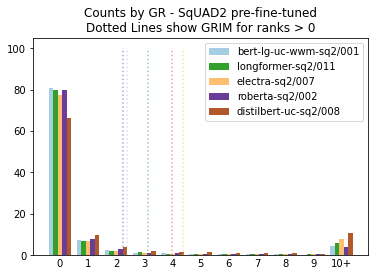

GRIMs: [2.38 3.13 4.38 2.23 3.99]
EMs [80.91 79.92 77.61 79.92 66.31]


In [22]:
#from utils_anal import plot_golden_EM_by_rank
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rankEval.png' ,
                subject = 'SqUAD2 pre-fine-tuned')
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

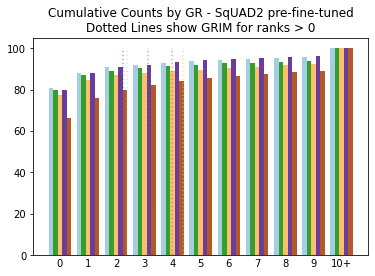

In [23]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rankEval.png'  ,
                subject = 'SqUAD2 pre-fine-tuned')


## Top-10 GRs Same Models with Our Added Fine-Tuning

These are the same models that have been fine-tuned by their authors, but we extended the fine-tuning with an additional up to 8 epochs

In [24]:
L = [i for i in range(len(RS.labels)) if i not in L_eval and i > 3]

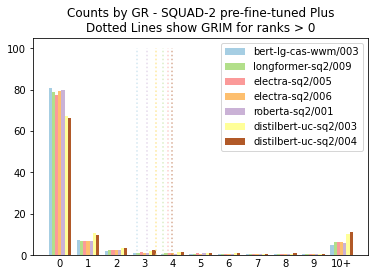

GRIMs: [2.73 3.65 3.84 3.4  3.11 3.41 3.97]
EMs [80.73 78.99 77.48 79.36 79.84 67.27 66.1 ]


In [25]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_ft_trVal.png'  ,
                subject = 'SQUAD-2 pre-fine-tuned Plus')
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

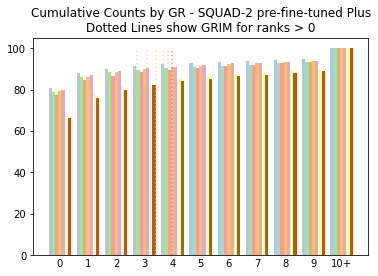

In [26]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_ft_trVal.png'   ,
                subject = 'SQUAD-2 pre-fine-tuned Plus')


## Top-10 GRs BERT

These are BERT models that were pre-trained but not fine-tuned. We fine-tune them with 8 epochs of training. The only exception is the large BERT with the suffix "eval" which is fine-tuned and used without any training. Notice that this is not the same as the cased large we used and which we trained. 

In [27]:
#L = [i for i in range(len(RS.labels)) if 'bert-large' in RS.labels[i] or (i>11 and '/na/' not in RS.labels[i]) ]
#L = [i for i in range(len(RS.labels)) if  (i>11 and '/na/' not in RS.labels[i]) and 'large' not in RS.labels[i] ]
L = [0,1,2,3]

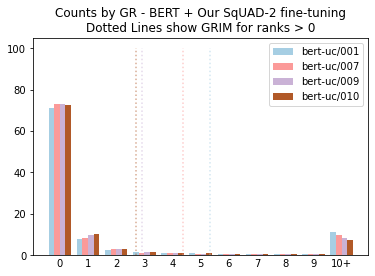

GRIMs: [5.34 4.38 2.91 2.7 ]
EMs [71.26 73.09 73.03 72.53]


In [28]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_bert.png'  ,
                subject = 'BERT + Our SqUAD-2 fine-tuning' )
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

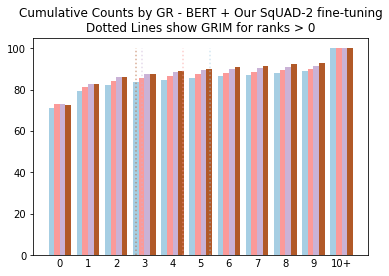

In [29]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_bert.png' ,
                subject = 'BERT + Our SqUAD-2 fine-tuning' )


## Top-10 GRs Electra & Roberta

In [30]:
L = [i for i in range(len(RS.labels)) if 'electra' in RS.labels[i] or 'roberta' in RS.labels[i]]

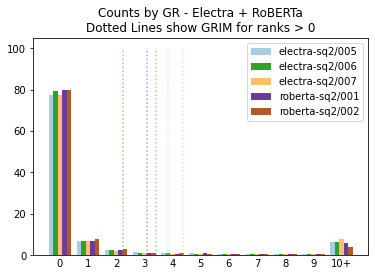

GRIMs: [3.84 3.4  4.38 3.11 2.23]
EMs [77.48 79.36 77.61 79.84 79.92]


In [31]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_electra.png' ,
                subject = 'Electra + RoBERTa' )
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

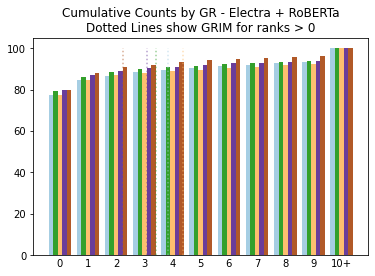

In [32]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_electra.png' ,
                subject = 'Electra + RoBERTa'  )


## Top-10 GRs Fine-Tuned DistilBERT & Longformer

In [33]:
L = [i for i in range(len(RS.labels)) if 'distil' in RS.labels[i] or 'former' in RS.labels[i]]

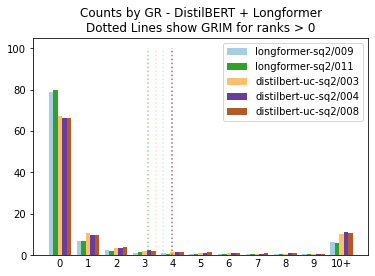

GRIMs: [3.65 3.13 3.41 3.97 3.99]
EMs [78.99 79.92 67.27 66.1  66.31]


In [34]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_long_dist.png' ,
                subject = 'DistilBERT + Longformer'  )
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

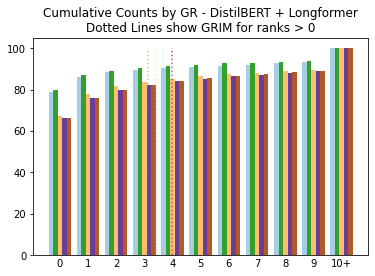

In [35]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_long_dist.png'  ,
                subject = 'DistilBERT + Longformer')


## Top-10 GRs BERT Large (Cased vs. Uncased)

In [36]:
L = [i for i in range(len(RS.labels)) if 'bert-l' in RS.labels[i]]

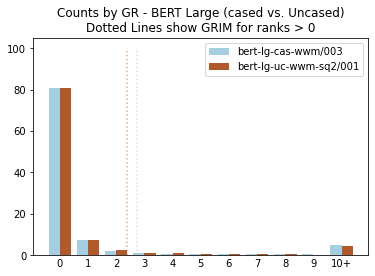

GRIMs: [2.73 2.38]
EMs [80.73 80.91]


In [37]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_bertLarge.png'  ,
                subject = 'BERT Large (cased vs. Uncased)')
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

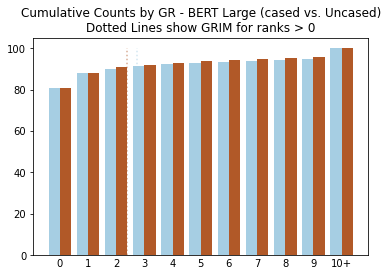

In [38]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_bertLarge.png' ,
                subject = 'BERT Large (cased vs. Uncased)' )


## Top-100 Golden Prediction Ranks > 0 (One Experiment)

In [39]:
grls_np_100, _ , _ ,_, _ = RS.calc_golden_ranks(
    maxBins = 100,experimentIdx=2)

/tmp/ipykernel_38670/2232140134.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "alpha" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('../assets/EM_rank100.png',dpi=300,alpha=0.6)


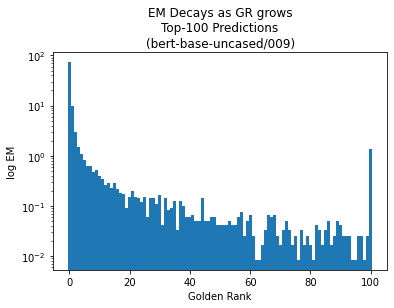

In [40]:
#Hs,Ms = plot_golden_EM_by_rank(grls_np_100, medians=[], cumulative = False,
#        skipRank0=False,labels=RS.labels,savePath='../assets/EM_rank100.png' )
lowx =0 #if skipRank0 else 0
title = 'EM Decays as GR grows\nTop-100 Predictions\n(bert-base-uncased/009)' 
#title = '%s%s' % (title,'\n(Ranks > 0 only)' if skipRank0 else '')
m = grls_np_100.shape[1]
maxBins = np.max(grls_np_100)
bins = [x for x in range(maxBins+2)]
A = plt.hist(grls_np_100.T,bins=maxBins+1,
        weights=np.ones(grls_np_100.T.shape)*100/m, 
        cumulative=False,align='left',histtype='bar',
        range=(lowx,(maxBins+1)))
plt.title(title)
plt.yscale("log")
plt.ylabel("log EM")
plt.xlabel("Golden Rank")
plt.savefig('../assets/EM_rank100.png',dpi=300,alpha=0.6)
plt.show()


# The Metrics


In [41]:
colors = cm.Paired(np.linspace(0, 1, 6))
cmap=sns.color_palette("tab10")
print(cmap)
colors = [cmap[i] for i in [0,0,0,1,2,2,2,3,3,4,4,5,5,5,1]]

metrics = RS.eval_metrics()
metrics['GRIM'] = medians
metrics['label'] = RS.labels
metrics['Model'] = [lbl.split('-')[0] for lbl in RS.labels]
metrics['Model'] = ['bert-lg' if 'bert-lg' in lbl else mod for mod,lbl in zip(metrics['Model'],RS.labels)]


metrics

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


,EM_ans,F1_ans,F1-EM_ans_delta,noans,EM,F1,F1-EM_delta,GRIM,label,Model
0,70.951417,78.934411,7.982994,71.572750,71.262528,75.248310,3.985782,5.339695,bert-uc/001,bert
1,69.129555,76.915674,7.786119,77.022708,73.081782,76.969268,3.887485,4.383621,bert-uc/007,bert
2,68.522267,75.441761,6.919494,77.527334,73.031247,76.486041,3.454793,2.909091,bert-uc/009,bert
3,67.594467,74.788812,7.194345,77.443230,72.525899,76.117921,3.592022,2.700935,bert-uc/010,bert
4,76.180837,82.230080,6.049243,85.264929,80.729386,83.749677,3.020291,2.726027,bert-lg-cas-wwm/003,bert-lg
5,79.487179,85.444250,5.957071,82.321278,80.906258,83.880528,2.974271,2.379365,bert-lg-uc-wwm-sq2/001,bert-lg
6,75.033738,82.738118,7.704380,82.910008,78.977512,82.824186,3.846674,3.650000,longformer-sq2/009,longformer
7,78.677463,85.534793,6.857330,81.126997,79.903984,83.327740,3.423756,3.125767,longformer-sq2/011,longformer
8,77.918354,85.303190,7.384836,77.022708,77.469890,81.157021,3.687131,3.843750,electra-sq2/005,electra
9,77.378543,85.117483,7.738940,81.328848,79.356523,83.220453,3.863930,3.398601,electra-sq2/006,electra


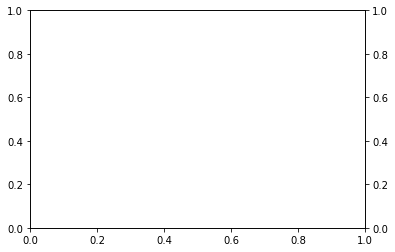

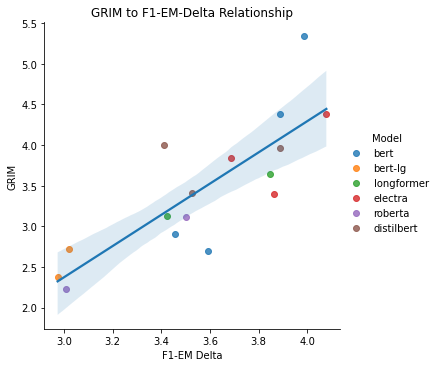

In [42]:
fig, ax = plt.subplots()
sns.lmplot(x='F1-EM_delta',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
ax2 = ax.twinx()
sns.regplot(x='F1-EM_delta',y='GRIM',data=metrics,scatter=False)#, hue='Model')
#ax.set(xlabel="x-axis", ylabel="y-axis")plt.ylim(6.0, 0)
plt.title("GRIM to F1-EM-Delta Relationship")
#plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('F1-EM Delta')
plt.ylabel('GRIM')
plt.savefig('../assets/F1-EM_vs_GRIM_correlation.png',dpi=300,bbox_inches='tight')
plt.show()

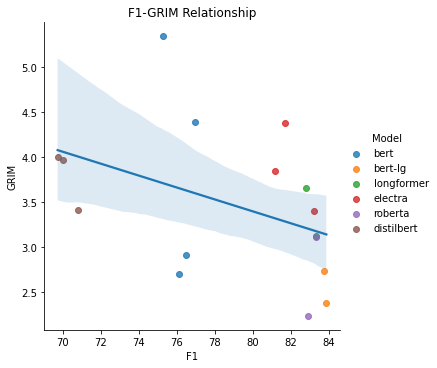

In [43]:
sns.lmplot(x='F1',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
ax2 = ax.twinx()
sns.regplot(x='F1',y='GRIM',data=metrics,scatter=False)#, hue='Model')

plt.title("F1-GRIM Relationship")
plt.xlabel('F1')
plt.ylabel('GRIM')
plt.savefig('../assets/F1_vs_GRIM_correlation.png',dpi=300,bbox_inches='tight')

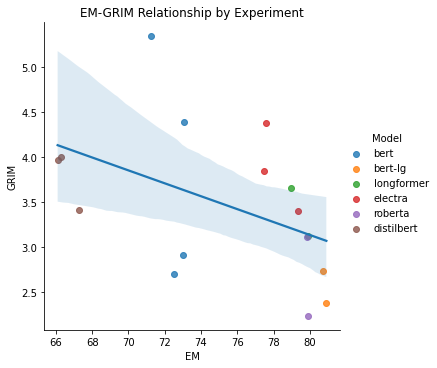

In [44]:
sns.lmplot(x='EM',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
ax2 = ax.twinx()
sns.regplot(x='EM',y='GRIM',data=metrics,scatter=False)#, hue='Model')

plt.title("EM-GRIM Relationship by Experiment")
#plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('EM')
plt.ylabel('GRIM')
plt.savefig('../assets/EM_vs_GRIM_correlation.png',dpi=300,bbox_inches='tight')

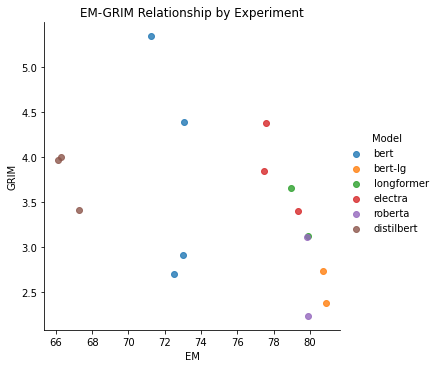

In [45]:
sns.lmplot(x='EM',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
#ax2 = ax.twinx()
#sns.regplot(x='EM',y='GRIM',data=metrics,scatter=False)#, hue='Model')

plt.title("EM-GRIM Relationship by Experiment")
#plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('EM')
plt.ylabel('GRIM')
plt.savefig('../assets/EM_vs_GRIM_scatter.png',dpi=300,bbox_inches='tight')

# Clustering of Examples by Model Performance

In [46]:
grs = grls_np # GR by example X experiment
grs_na = grls_np[:,list(nas_np[0,:])]
grs_ans = grls_np[:,list(nas_np[0,:]==0)]
grs_means = [np.mean(x) for x in grs.T]
grs_na_means = [np.mean(x) for x in grs_na.T]
grs_ans_means = [np.mean(x) for x in grs_ans.T]
grs_std = [np.std(x) for x in grs.T]
grs_na_std = [np.std(x) for x in grs_na.T]
grs_ans_std = [np.std(x) for x in grs_ans.T]
grs_pr = grls_np[:,list(np.min(grls_np,axis=0) == 0)]

#grs_pr_na = grls_np[:,list(np.min(grls_np,axis=0) == 0 and nas_np[0,:])]

grs_sec = grls_np[:,list(np.min(grls_np,axis=0) > 0)]
grs_pr_means = [np.mean(x) for x in grs_pr.T]
grs_pr_std = [np.std(x) for x in grs_pr.T]
grs_sec_means = [np.mean(x) for x in grs_sec.T]
grs_sec_std = [np.std(x) for x in grs_sec.T]


In [47]:
print("na",len(grs_na_means))
print("ans",len(grs_ans_means))
print("all",grs.shape)



na 5945
ans 5928
all (16, 11873)


In [48]:
X = np.max(grls_np,axis=0)
XX = np.sum(grls_np<10,axis=1)
X10 = np.sum(X<10)
XX10 = np.mean(XX)
print(XX10)
m = X.shape[0]
print(X.shape)
print('There are %i examples (%.2f) that are consistently under rank 10'%(X10,X10/m*100))
print('The average experiment has %i examples (%.2f)%% under rank 10'% (XX10,XX10/m*100))
print('The best experiment has %i examples (%.2f)%% under rank 10'% (np.max(XX),np.max(XX)/m*100))

10969.875
(11873,)
There are 8576 examples (72.23) that are consistently under rank 10
The average experiment has 10969 examples (92.39)% under rank 10
The best experiment has 11418 examples (96.17)% under rank 10


## GR Mean & std of All experiments by Example

We plot the 16 experiment golden rank mean vs. the standard deviation for each example. The first plot below distinguishes the examples into two categories: The gray points denote those examples predicted  correctly by at least one experiment. The blue points denote the rest of the examples that only appeared in secondary predictions.

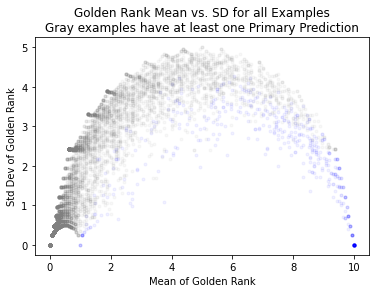

In [49]:
plt.scatter(grs_pr_means,grs_pr_std,alpha = 0.05, marker = '.',color = 'grey')
plt.scatter(grs_sec_means,grs_sec_std,alpha = 0.05, marker = '.',color = 'blue')
plt.xlabel("Mean of Golden Rank")
plt.ylabel("Std Dev of Golden Rank")
plt.title("Golden Rank Mean vs. SD for all Examples\nGray examples have at least one Primary Prediction")
plt.savefig('../assets/GR_mean_vs_std_Predicted_by_at_least_one_model.png',dpi=300)

The following statistics pertain to examples that have been predicted correctly at least once:

In [50]:
m=grls_np.shape[1]
pr_na = np.sum([ a and b for (a,b) in zip(nas_np[0,:],np.min(grls_np,axis=0) == 0) ])
pr_ans = np.sum([ not a and b for (a,b) in zip(nas_np[0,:],np.min(grls_np,axis=0) == 0) ])
pr = np.sum(np.min(grls_np,axis=0) == 0)
print('Total number of examples:',m)
print ('There are %i examples that have been predicted correctly by at leat one experiment' % pr)
print('They are about evenly split between answerable (%i) and unanswearable (%i) examples'% (pr_ans,pr_na))
print ('The remaining %i examples (%.2f%%) are the only ones that appear exclusively in secondary predictions and none of the primary' %\
    (m-pr, (m-pr)/m*100))


Total number of examples: 11873
There are 11397 examples that have been predicted correctly by at leat one experiment
They are about evenly split between answerable (5651) and unanswearable (5746) examples
The remaining 476 examples (4.01%) are the only ones that appear exclusively in secondary predictions and none of the primary


The second graph shows the same mean-standard deviation plot for each example, in green for answerable examples and  red for those that have no answer.The answerable examples are more consistently predicted by the 16 models and remain closer to the higher ranking predictions (towards 0) while the no-answer examples are predicted less successfully and with wider variability.

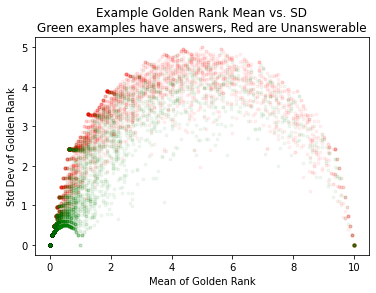

In [51]:
plt.scatter(grs_na_means,grs_na_std,alpha = 0.05, marker = '.',color = 'red')
plt.scatter(grs_ans_means,grs_ans_std,alpha = 0.05, marker = '.',color = 'green')
plt.xlabel("Mean of Golden Rank")
plt.ylabel("Std Dev of Golden Rank")
plt.title("Example Golden Rank Mean vs. SD\nGreen examples have answers, Red are Unanswerable")
plt.savefig('../assets/GR_mean_vs_std_ans_vs_noAns.png',dpi=300)

The following experiment counts correspond to the three points with zero standard deviation. These denote examples that have been consistently ranked for all 15 experiments.

In [52]:
m = len(grs_means)
print('Examples ranked 0 for all experiments: %i or %.2f%%'%(np.sum([x==0 for x in grs_means]),np.sum([x==0 for x in grs_means])/m*100))
print('Examples ranked 10 or higher for all experiments: %i or %.2f%%'%(np.sum([x==10 for x in grs_means]),np.sum([x==10 for x in grs_means])/m*100))
v01 = np.sum([x==0 for x in grs_std])-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
print('Examples ranked 1 for all experiments: %i or %.2f%%' % (v01,v01/m*100))
print('Examples ranked 0 for all experiments with no answer: %i or %.2f%%'%(np.sum([x==0 for x in grs_na_means]),np.sum([x==0 for x in grs_na_means])/m*100))
print('Examples ranked 10 or higher for all experiments with no answer: %i or %.2f%%'%(np.sum([x==10 for x in grs_na_means]),np.sum([x==10 for x in grs_na_means])/m*100))
v11 = np.sum([x==0 for x in grs_na_std])-np.sum([x==10 for x in grs_na_means])-np.sum([x==0 for x in grs_na_means])
print('Examples ranked 1 for all experiments with no answer: %i or %.2f%%'%(v11,v11/m*100))
print('Examples ranked 0 for all answerable experiments: %i or %.2f%%'%(np.sum([x==0 for x in grs_ans_means]),np.sum([x==0 for x in grs_ans_means])/m*100))
print('Examples ranked 10 or higher for all answerable experiments: %i or %.2f%%'%(np.sum([x==10 for x in grs_ans_means]),np.sum([x==10 for x in grs_ans_means])/m*100))
v21=np.sum([x==0 for x in grs_ans_std])-np.sum([x==10 for x in grs_ans_means])-np.sum([x==0 for x in grs_ans_means])
print('Examples ranked 1 for all answerable experiments: %i or %.2f%%'%(v21,v21/m*100))



#grs.shape

Examples ranked 0 for all experiments: 4654 or 39.20%
Examples ranked 10 or higher for all experiments: 44 or 0.37%
Examples ranked 1 for all experiments: 4 or 0.03%
Examples ranked 0 for all experiments with no answer: 2538 or 21.38%
Examples ranked 10 or higher for all experiments with no answer: 24 or 0.20%
Examples ranked 1 for all experiments with no answer: 0 or 0.00%
Examples ranked 0 for all answerable experiments: 2116 or 17.82%
Examples ranked 10 or higher for all answerable experiments: 20 or 0.17%
Examples ranked 1 for all answerable experiments: 4 or 0.03%


In [53]:
from IPython.display import display, HTML

def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))


## Error Analysis - Clusters of Interest

### Four rank-1, sdv-0 examples
The next cell produces the four examples that rank 1 for all experiments. The result shows that three of them involve an incorrect "No Answer" prediction and one looks like an aberration in the golden answers where the returned rank-0 answer should be a correct answer. 

In [54]:
df = RS.topNPredsDF()#topK=5)#, experimentIdx =experimentID)
df['experiment'] = [abbrevLabel[exp] for exp in df['experiment']]
df['id_short'] = [i[20:] for i in df['id']]

In [55]:
pd.set_option('display.max_colwidth', 0)
[(x,y) for x,y in zip(grs_std,grs_means) if x ==0 and y == 1]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = np.where(np.prod(grs,axis=0)==1)[0].tolist()
print(ixs)
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in np.where(np.prod(grs,axis=0)==1)[0].tolist()]
print(ids)
df1 = df.loc[df.id.isin(ids)][['text','probability','id_short','rank','goldAns','correct']]
with open('../assets/errors_GR1_example_predictions_4.tex','w') as F:
    F.write(df1.query('rank < 2').to_latex(index=False))
display( df1.query('rank < 2'))



[4425, 5088, 5557, 5860]
['57263c78ec44d21400f3dc7c', '57267d52708984140094c7da', '5728dc2d3acd2414000e0080', '572742bd5951b619008f8787']


/tmp/ipykernel_38670/848896863.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df1.query('rank < 2').to_latex(index=False))


,text,probability,id_short,rank,goldAns,correct
46383,,0.999946,dc7c,0,"[Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core, the division of functions and tasks between the hosts at the edge of the network and the network core., division of functions and tasks between the hosts at the edge of the network and the network core]",False
46384,Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core,0.000045,dc7c,1,"[Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core, the division of functions and tasks between the hosts at the edge of the network and the network core., division of functions and tasks between the hosts at the edge of the network and the network core]",True
53241,microscopic analysis of oriented thin sections of geologic samples,0.518779,c7da,0,"[microscopic analysis, microscopic analysis of oriented thin sections, use microscopic analysis of oriented thin sections of geologic samples]",False
53242,microscopic analysis,0.481057,c7da,1,"[microscopic analysis, microscopic analysis of oriented thin sections, use microscopic analysis of oriented thin sections of geologic samples]",True
58120,,1.000000,0080,0,[Brownlee],False
...,...,...,...,...,...,...
2948090,microscopic analysis of oriented thin sections,0.200961,c7da,1,"[microscopic analysis, microscopic analysis of oriented thin sections, use microscopic analysis of oriented thin sections of geologic samples]",True
2952926,,0.996014,0080,0,[Brownlee],False
2952927,Brownlee,0.003980,0080,1,[Brownlee],True
2956002,,0.995019,8787,0,"[waste, a lot of waste]",False


### Sample of highly polarized examples

In [56]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if std> 4.8  ]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = [exs[0] for exs in random.sample(ixs,5)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs]
print(ids)
for id in ids:
    print('Example ID:',id)
    print(RS.dataset[RS.ix_id[id]])
    df1 = df.query('id == @id and (rank < 2 or correct == True)')
    #df1 = df.loc[(df.id==id & (df.rank == 0 or df.correct == True))]
    #df1['experiment'] = [abbrevLabel[exp] for exp in df1['experiment']]
    for experimentID in range(16):
        #[RS.topNPreds()[1][id][0] for id in ids]
        #df1['id'] = [i[20:] for i in df1['id']]
        df2 = df1[['text','probability','experiment','rank','goldAns','correct']]
        #wrap_df_text(df1)
    with open('../assets/errors_GR_polar_by_experiment_id_%s.tex'%id,'w') as F:
        F.write(df2.to_latex(index=False))
    display( df2)#.query('rank < 5'))

['5a38aa28a4b263001a8c1881', '5a582cfa770dc0001aef0015', '5a665002846392001a1e1ab4', '5ad40397604f3c001a3ffd86', '5ad4db615b96ef001a10a436']
Example ID: 5a38aa28a4b263001a8c1881
{'id': '5a38aa28a4b263001a8c1881', 'title': '1973_oil_crisis', 'context': 'The crisis had a major impact on international relations and created a rift within NATO. Some European nations and Japan sought to disassociate themselves from United States foreign policy in the Middle East to avoid being targeted by the boycott. Arab oil producers linked any future policy changes to peace between the belligerents. To address this, the Nixon Administration began multilateral negotiations with the combatants. They arranged for Israel to pull back from the Sinai Peninsula and the Golan Heights. By January 18, 1974, US Secretary of State Henry Kissinger had negotiated an Israeli troop withdrawal from parts of the Sinai Peninsula. The promise of a negotiated settlement between Israel and Syria was enough to convince Arab oi

/tmp/ipykernel_38670/3179061714.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
28420,peace between the belligerents,5.003291e-01,bert-uc/001,0,[],False
28421,peace between the belligerents.,1.662935e-01,bert-uc/001,1,[],False
28430,,8.281260e-11,bert-uc/001,10,[],True
152399,peace between the belligerents,7.838687e-01,bert-uc/007,0,[],False
152400,any future policy changes to peace between the belligerents,1.067032e-01,bert-uc/007,1,[],False
152409,,3.808374e-06,bert-uc/007,10,[],True
518815,peace between the belligerents,3.040798e-01,bert-uc/009,0,[],False
518816,any future policy changes to peace between the belligerents,2.016422e-01,bert-uc/009,1,[],False
518846,,1.493495e-04,bert-uc/009,31,[],True
518867,.,1.742224e-05,bert-uc/009,52,[],True


Example ID: 5a582cfa770dc0001aef0015
{'id': '5a582cfa770dc0001aef0015', 'title': 'Geology', 'context': "Sir Charles Lyell first published his famous book, Principles of Geology, in 1830. This book, which influenced the thought of Charles Darwin, successfully promoted the doctrine of uniformitarianism. This theory states that slow geological processes have occurred throughout the Earth's history and are still occurring today. In contrast, catastrophism is the theory that Earth's features formed in single, catastrophic events and remained unchanged thereafter. Though Hutton believed in uniformitarianism, the idea was not widely accepted at the time.", 'question': 'What did Charles Darwin successfully promote?', 'answers': {'text': [], 'answer_start': []}}


/tmp/ipykernel_38670/3179061714.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
54350,the doctrine of uniformitarianism,8.955185e-01,bert-uc/001,0,[],False
54351,the doctrine of uniformitarianism.,4.975741e-02,bert-uc/001,1,[],False
54360,,1.451596e-09,bert-uc/001,10,[],True
178213,,8.483472e-01,bert-uc/007,0,[],True
178214,uniformitarianism.,7.651095e-02,bert-uc/007,1,[],False
767411,,9.998425e-01,bert-uc/009,0,[],True
767412,uniformitarianism,1.130688e-04,bert-uc/009,1,[],False
767448,the,6.928876e-09,bert-uc/009,37,[],True
1489363,,9.712009e-01,bert-uc/010,0,[],True
1489364,the doctrine of uniformitarianism,1.569755e-02,bert-uc/010,1,[],False


Example ID: 5a665002846392001a1e1ab4
{'id': '5a665002846392001a1e1ab4', 'title': 'Civil_disobedience', 'context': "Civil disobedience is usually defined as pertaining to a citizen's relation to the state and its laws, as distinguished from a constitutional impasse in which two public agencies, especially two equally sovereign branches of government, conflict. For instance, if the head of government of a country were to refuse to enforce a decision of that country's highest court, it would not be civil disobedience, since the head of government would be acting in her or his capacity as public official rather than private citizen.", 'question': 'What else does an agency have a relationship with under the civil disobedience definition?', 'answers': {'text': [], 'answer_start': []}}


/tmp/ipykernel_38670/3179061714.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
57873,two equally sovereign branches of government,7.948192e-01,bert-uc/001,0,[],False
57874,private citizen,1.817420e-01,bert-uc/001,1,[],False
57883,,6.844141e-07,bert-uc/001,10,[],True
181705,its laws,3.267582e-01,bert-uc/007,0,[],False
181706,state and its laws,2.265760e-01,bert-uc/007,1,[],False
181715,,1.416643e-04,bert-uc/007,10,[],True
801237,state and its laws,3.948609e-01,bert-uc/009,0,[],False
801238,the state and its laws,3.548994e-01,bert-uc/009,1,[],False
801271,,8.252200e-05,bert-uc/009,34,[],True
801280,the,3.063222e-05,bert-uc/009,43,[],True


Example ID: 5ad40397604f3c001a3ffd86
{'id': '5ad40397604f3c001a3ffd86', 'title': 'Yuan_dynasty', 'context': "Kublai Khan promoted commercial, scientific, and cultural growth. He supported the merchants of the Silk Road trade network by protecting the Mongol postal system, constructing infrastructure, providing loans that financed trade caravans, and encouraging the circulation of paper banknotes (鈔, Chao). Pax Mongolica, Mongol peace, enabled the spread of technologies, commodities, and culture between China and the West. Kublai expanded the Grand Canal from southern China to Daidu in the north. Mongol rule was cosmopolitan under Kublai Khan. He welcomed foreign visitors to his court, such as the Venetian merchant Marco Polo, who wrote the most influential European account of Yuan China. Marco Polo's travels would later inspire many others like Christopher Columbus to chart a passage to the Far East in search of its legendary wealth.", 'question': 'Where did Kublai shorten the Grand Ca

/tmp/ipykernel_38670/3179061714.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
80233,Daidu,9.969040e-01,bert-uc/001,0,[],False
80234,Daidu in the north,2.728918e-03,bert-uc/001,1,[],False
80243,,5.309036e-17,bert-uc/001,10,[],True
203934,Daidu in the north,4.799386e-01,bert-uc/007,0,[],False
203935,Daidu,3.067735e-01,bert-uc/007,1,[],False
203944,,2.241374e-04,bert-uc/007,10,[],True
1015871,Daidu,4.597144e-01,bert-uc/009,0,[],False
1015872,Daidu in the north,2.460514e-01,bert-uc/009,1,[],False
1015905,,3.677215e-04,bert-uc/009,34,[],True
1514844,Daidu,2.715594e-01,bert-uc/010,0,[],False


Example ID: 5ad4db615b96ef001a10a436
{'id': '5ad4db615b96ef001a10a436', 'title': 'Immune_system', 'context': 'Overactive immune responses comprise the other end of immune dysfunction, particularly the autoimmune disorders. Here, the immune system fails to properly distinguish between self and non-self, and attacks part of the body. Under normal circumstances, many T cells and antibodies react with "self" peptides. One of the functions of specialized cells (located in the thymus and bone marrow) is to present young lymphocytes with self antigens produced throughout the body and to eliminate those cells that recognize self-antigens, preventing autoimmunity.', 'question': 'What is the function of specialize cells located in the brain?', 'answers': {'text': [], 'answer_start': []}}


/tmp/ipykernel_38670/3179061714.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
86666,to present young lymphocytes with self antigens produced throughout the body,9.911668e-01,bert-uc/001,0,[],False
86667,present young lymphocytes with self antigens produced throughout the body,6.581862e-03,bert-uc/001,1,[],False
86676,,2.101932e-12,bert-uc/001,10,[],True
210310,to present young lymphocytes with self antigens produced throughout the body and to eliminate those cells that recognize self-antigens,5.440310e-01,bert-uc/007,0,[],False
210311,present young lymphocytes with self antigens produced throughout the body and to eliminate those cells that recognize self-antigens,2.368791e-01,bert-uc/007,1,[],False
210320,,1.535907e-03,bert-uc/007,10,[],True
1076790,to present young lymphocytes with self antigens produced throughout the body,2.089644e-01,bert-uc/009,0,[],False
1076791,present young lymphocytes with self antigens produced throughout the body,1.969281e-01,bert-uc/009,1,[],False
1076890,,8.830592e-06,bert-uc/009,100,[],True
1521165,to present young lymphocytes with self antigens produced throughout the body,4.190452e-01,bert-uc/010,0,[],False


### Polarized Answerable Examples

In [57]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if std> 4.5  ]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = [x[0] for x in random.sample(ixs,40)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs and x['answers']['text'] != []]
print(ids)
for id in ids:
    print('Example ID:',id)
    df1 = df.query('id == @id and (rank < 2 or correct == True)')
    #df1 = df.loc[(df.id==id & (df.rank == 0 or df.correct == True))]
    for experimentID in range(16):
        #[RS.topNPreds()[1][id][0] for id in ids]
        #df1['id'] = [i[20:] for i in df1['id']]
        df2 = df1[['text','probability','experiment','rank','goldAns','correct']]
        #wrap_df_text(df1)
    with open('../assets/errors_GR_polar_answerable_%s.tex'%id,'w') as F:
        F.write(df2.query('rank < 5').to_latex(index=False))
    display( df2)#.query('rank < 5'))

['56de10b44396321400ee2595', '5705fec152bb89140068977b', '571cb27fdd7acb1400e4c133', '5728d63c4b864d1900164f1b', '5727e8424b864d1900163fc2', '573403394776f419006616e0']
Example ID: 56de10b44396321400ee2595


/tmp/ipykernel_38670/1723523256.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
577,Armenians,0.983769,bert-uc/001,0,[Turkish forces],False
578,the Armenians,0.003975,bert-uc/001,1,[Turkish forces],False
124646,Armenians,0.502794,bert-uc/007,0,[Turkish forces],False
124647,Some Normans joined Turkish forces to aid in the destruction of the Armenians,0.212526,bert-uc/007,1,[Turkish forces],False
252955,Armenians vassal-states of Sassoun and Taron,0.282015,bert-uc/009,0,[Turkish forces],False
252956,Armenians,0.274393,bert-uc/009,1,[Turkish forces],False
1436534,Armenians,0.563412,bert-uc/010,0,[Turkish forces],False
1436535,Armenians vassal-states of Sassoun and Taron,0.165457,bert-uc/010,1,[Turkish forces],False
1558608,Turkish forces,0.828547,bert-lg-cas-wwm/003,0,[Turkish forces],True
1558609,Turkish,0.110282,bert-lg-cas-wwm/003,1,[Turkish forces],False


Example ID: 5705fec152bb89140068977b


/tmp/ipykernel_38670/1723523256.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
8172,"about 10,000",0.872122,bert-uc/001,0,[small],False
8173,"10,000",0.124337,bert-uc/001,1,[small],False
132212,small,0.502760,bert-uc/007,0,[small],True
132213,Nearly all of them are so small,0.363316,bert-uc/007,1,[small],False
325775,small,0.424558,bert-uc/009,0,[small],True
325776,Nearly all of them are so small,0.179215,bert-uc/009,1,[small],False
1443981,small,0.362284,bert-uc/010,0,[small],True
1443982,"10,000 earthquakes. Nearly all of them are so small",0.300891,bert-uc/010,1,[small],False
1566117,Nearly all of them are so small,0.548742,bert-lg-cas-wwm/003,0,[small],False
1566118,small,0.119409,bert-lg-cas-wwm/003,1,[small],True


Example ID: 571cb27fdd7acb1400e4c133


/tmp/ipykernel_38670/1723523256.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
26251,ice core,0.814572,bert-uc/001,0,"[what the climate was like millions of years ago, temperatures, climate]",False
26252,ice core samples that are up to several hundreds of thousands of years old.,0.045771,bert-uc/001,1,"[what the climate was like millions of years ago, temperatures, climate]",False
150233,,0.990861,bert-uc/007,0,"[what the climate was like millions of years ago, temperatures, climate]",False
150234,"lower global temperatures, snow and rain",0.005701,bert-uc/007,1,"[what the climate was like millions of years ago, temperatures, climate]",False
498198,snow and rain,0.454572,bert-uc/009,0,"[what the climate was like millions of years ago, temperatures, climate]",False
498199,"lower global temperatures, snow and rain",0.235187,bert-uc/009,1,"[what the climate was like millions of years ago, temperatures, climate]",False
498211,the climate,0.002892,bert-uc/009,13,"[what the climate was like millions of years ago, temperatures, climate]",True
498215,climate,0.002315,bert-uc/009,17,"[what the climate was like millions of years ago, temperatures, climate]",True
498232,temperatures,0.000441,bert-uc/009,34,"[what the climate was like millions of years ago, temperatures, climate]",True
1461739,Seawater,0.318287,bert-uc/010,0,"[what the climate was like millions of years ago, temperatures, climate]",False


/tmp/ipykernel_38670/1723523256.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


Example ID: 5728d63c4b864d1900164f1b


,text,probability,experiment,rank,goldAns,correct
57386,Henry David Thoreau,9.999995e-01,bert-uc/001,0,[Gandhi],False
57387,eau,5.051956e-07,bert-uc/001,1,[Gandhi],False
181220,Henry David Thoreau,9.999856e-01,bert-uc/007,0,[Gandhi],False
181221,Henry,7.086331e-06,bert-uc/007,1,[Gandhi],False
796537,Henry David Thoreau,9.637657e-01,bert-uc/009,0,[Gandhi],False
796538,,2.094938e-02,bert-uc/009,1,[Gandhi],False
796584,Gandhi,6.826181e-07,bert-uc/009,47,[Gandhi],True
796607,Gandhi,3.568487e-07,bert-uc/009,70,[Gandhi],True
1492358,Henry David Thoreau,7.287480e-01,bert-uc/010,0,[Gandhi],False
1492359,,2.557302e-01,bert-uc/010,1,[Gandhi],False


/tmp/ipykernel_38670/1723523256.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


Example ID: 5727e8424b864d1900163fc2


,text,probability,experiment,rank,goldAns,correct
70226,"Inherited wealth may help explain why many Americans who have become rich may have had a ""substantial head start""",0.739520,bert-uc/001,0,[Inherited wealth],False
70227,"substantial head start""",0.241632,bert-uc/001,1,[Inherited wealth],False
193972,"substantial head start""",0.571482,bert-uc/007,0,[Inherited wealth],False
193973,substantial head start,0.185976,bert-uc/007,1,[Inherited wealth],False
919803,"substantial head start""",0.266552,bert-uc/009,0,[Inherited wealth],False
919804,substantial head start,0.168539,bert-uc/009,1,[Inherited wealth],False
919889,Inherited wealth,0.000058,bert-uc/009,86,[Inherited wealth],True
1504980,"substantial head start""",0.233866,bert-uc/010,0,[Inherited wealth],False
1504981,substantial head start,0.166133,bert-uc/010,1,[Inherited wealth],False
1627635,substantial head start,0.463495,bert-lg-cas-wwm/003,0,[Inherited wealth],False


Example ID: 573403394776f419006616e0


/tmp/ipykernel_38670/1723523256.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
119513,Abercrombie was recalled,9.825765e-01,bert-uc/001,0,"[was recalled and replaced by Jeffery Amherst, recalled and replaced by Jeffery Amherst, victor at Louisbourg., Abercrombie was recalled and replaced, recalled and replaced, Abercrombie was recalled and replaced by Jeffery Amherst,]",False
119514,bie was recalled,1.448545e-02,bert-uc/001,1,"[was recalled and replaced by Jeffery Amherst, recalled and replaced by Jeffery Amherst, victor at Louisbourg., Abercrombie was recalled and replaced, recalled and replaced, Abercrombie was recalled and replaced by Jeffery Amherst,]",False
119522,"recalled and replaced by Jeffery Amherst, victor at Louisbourg.",2.488962e-07,bert-uc/001,9,"[was recalled and replaced by Jeffery Amherst, recalled and replaced by Jeffery Amherst, victor at Louisbourg., Abercrombie was recalled and replaced, recalled and replaced, Abercrombie was recalled and replaced by Jeffery Amherst,]",True
243006,saved something from the disaster when he sent John Bradstreet on an expedition that successfully destroyed Fort Frontenac,3.018005e-01,bert-uc/007,0,"[was recalled and replaced by Jeffery Amherst, recalled and replaced by Jeffery Amherst, victor at Louisbourg., Abercrombie was recalled and replaced, recalled and replaced, Abercrombie was recalled and replaced by Jeffery Amherst,]",False
243007,Abercrombie saved something from the disaster when he sent John Bradstreet on an expedition that successfully destroyed Fort Frontenac,2.532410e-01,bert-uc/007,1,"[was recalled and replaced by Jeffery Amherst, recalled and replaced by Jeffery Amherst, victor at Louisbourg., Abercrombie was recalled and replaced, recalled and replaced, Abercrombie was recalled and replaced by Jeffery Amherst,]",False
...,...,...,...,...,...,...
2768248,Abercrombie saved something from the disaster when he sent John Bradstreet on an expedition that successfully destroyed Fort Frontenac,2.114097e-01,distilbert-uc-sq2/003,1,"[was recalled and replaced by Jeffery Amherst, recalled and replaced by Jeffery Amherst, victor at Louisbourg., Abercrombie was recalled and replaced, recalled and replaced, Abercrombie was recalled and replaced by Jeffery Amherst,]",False
2890915,Abercrombie saved something from the disaster,5.246378e-01,distilbert-uc-sq2/004,0,"[was recalled and replaced by Jeffery Amherst, recalled and replaced by Jeffery Amherst, victor at Louisbourg., Abercrombie was recalled and replaced, recalled and replaced, Abercrombie was recalled and replaced by Jeffery Amherst,]",False
2890916,Abercrombie saved something from the disaster when he sent John Bradstreet on an expedition that successfully destroyed Fort Frontenac,3.814569e-01,distilbert-uc-sq2/004,1,"[was recalled and replaced by Jeffery Amherst, recalled and replaced by Jeffery Amherst, victor at Louisbourg., Abercrombie was recalled and replaced, recalled and replaced, Abercrombie was recalled and replaced by Jeffery Amherst,]",False
3013793,Abercrombie saved something from the disaster when he sent John Bradstreet on an expedition that successfully destroyed Fort Frontenac,3.630170e-01,distilbert-uc-sq2/008,0,"[was recalled and replaced by Jeffery Amherst, recalled and replaced by Jeffery Amherst, victor at Louisbourg., Abercrombie was recalled and replaced, recalled and replaced, Abercrombie was recalled and replaced by Jeffery Amherst,]",False


### All Experiments in Rank 10+

In [58]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if mu == 10  ]
ixs = [x[0] for x in random.sample(ixs,10)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs and x['answers']['text'] != []]
print(ids)
for id in ids:
    print('Example ID:',id)
    df1 = df.query('id == @id and (rank < 3 or correct == True)')
    #df1 = df.loc[(df.id==id & (df.rank == 0 or df.correct == True))]
    for experimentID in range(16):
        #[RS.topNPreds()[1][id][0] for id in ids]
        #df1['id'] = [i[20:] for i in df1['id']]
        df2 = df1[['text','probability','experiment','rank','goldAns','correct']]
        #wrap_df_text(df1)
    with open('../assets/errors_GR_10_Plus_%s.tex'%id,'w') as F:
        F.write(df2.query('rank < 5').to_latex(index=False))
    display( df2)#.query('rank < 5'))

['57111713a58dae1900cd6c00', '571cd703dd7acb1400e4c185', '57269e3bf1498d1400e8e51a', '5728e5f43acd2414000e0174', '572945b11d04691400779230', '572fe1d404bcaa1900d76e37', '5730069004bcaa1900d7702e']
Example ID: 57111713a58dae1900cd6c00


/tmp/ipykernel_38670/3874880506.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
18652,quickly and often married outside their immediate French communities,0.980224,bert-uc/001,0,"[affiliated with other Protestant denominations, affiliated with other Protestant denominations with more numerous members]",False
18653,adapted quickly and often married outside their immediate French communities,0.013101,bert-uc/001,1,"[affiliated with other Protestant denominations, affiliated with other Protestant denominations with more numerous members]",False
18654,married outside their immediate French communities,0.002958,bert-uc/001,2,"[affiliated with other Protestant denominations, affiliated with other Protestant denominations with more numerous members]",False
142640,often married outside their immediate French communities,0.343574,bert-uc/007,0,"[affiliated with other Protestant denominations, affiliated with other Protestant denominations with more numerous members]",False
142641,"often married outside their immediate French communities,",0.178540,bert-uc/007,1,"[affiliated with other Protestant denominations, affiliated with other Protestant denominations with more numerous members]",False
142642,The Huguenots adapted quickly and often married outside their immediate French communities,0.098299,bert-uc/007,2,"[affiliated with other Protestant denominations, affiliated with other Protestant denominations with more numerous members]",False
425952,married,0.133709,bert-uc/009,0,"[affiliated with other Protestant denominations, affiliated with other Protestant denominations with more numerous members]",False
425953,The Huguenots adapted quickly,0.098988,bert-uc/009,1,"[affiliated with other Protestant denominations, affiliated with other Protestant denominations with more numerous members]",False
425954,married outside their immediate French communities,0.075320,bert-uc/009,2,"[affiliated with other Protestant denominations, affiliated with other Protestant denominations with more numerous members]",False
1454286,Huguenots adapted quickly and often married outside their immediate French communities,0.227925,bert-uc/010,0,"[affiliated with other Protestant denominations, affiliated with other Protestant denominations with more numerous members]",False


Example ID: 571cd703dd7acb1400e4c185


/tmp/ipykernel_38670/3874880506.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
27466,chemical bonds with almost all other elements to give corresponding oxides,0.992296,bert-uc/001,0,"[a thin film of oxide, oxide]",False
27467,oxides,0.005971,bert-uc/001,1,"[a thin film of oxide, oxide]",False
27468,oxygen forms chemical bonds with almost all other elements to give corresponding oxides,0.001312,bert-uc/001,2,"[a thin film of oxide, oxide]",False
151447,chemical bonds with almost all other elements to give corresponding oxides,0.878123,bert-uc/007,0,"[a thin film of oxide, oxide]",False
151448,chemical bonds,0.115410,bert-uc/007,1,"[a thin film of oxide, oxide]",False
151449,chemical bonds with almost all other elements,0.002549,bert-uc/007,2,"[a thin film of oxide, oxide]",False
509804,chemical bonds with almost all other elements to give corresponding oxides,0.775446,bert-uc/009,0,"[a thin film of oxide, oxide]",False
509805,chemical bonds,0.097449,bert-uc/009,1,"[a thin film of oxide, oxide]",False
509806,oxides,0.040966,bert-uc/009,2,"[a thin film of oxide, oxide]",False
509845,oxide,0.000028,bert-uc/009,41,"[a thin film of oxide, oxide]",True


Example ID: 57269e3bf1498d1400e8e51a


/tmp/ipykernel_38670/3874880506.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
33061,60,0.992298,bert-uc/001,0,[women retire at age 60 and men at 65],False
33062,60 and men at 65,0.007674,bert-uc/001,1,[women retire at age 60 and men at 65],False
33063,65,0.000026,bert-uc/001,2,[women retire at age 60 and men at 65],False
157043,60,0.983167,bert-uc/007,0,[women retire at age 60 and men at 65],False
157044,60 and men at 65,0.008183,bert-uc/007,1,[women retire at age 60 and men at 65],False
157045,age 60,0.005479,bert-uc/007,2,[women retire at age 60 and men at 65],False
563076,60,0.435714,bert-uc/009,0,[women retire at age 60 and men at 65],False
563077,60 and men at 65,0.231683,bert-uc/009,1,[women retire at age 60 and men at 65],False
563078,65,0.164138,bert-uc/009,2,[women retire at age 60 and men at 65],False
563106,women retire at age 60 and men at 65,0.000077,bert-uc/009,30,[women retire at age 60 and men at 65],True


Example ID: 5728e5f43acd2414000e0174


/tmp/ipykernel_38670/3874880506.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
59058,engaging in the forbidden speech,9.990937e-01,bert-uc/001,0,"[broadcasting, email, Supreme Court case, sending an email]",False
59059,forbidden speech,8.901673e-04,bert-uc/001,1,"[broadcasting, email, Supreme Court case, sending an email]",False
59060,speech,1.111836e-05,bert-uc/001,2,"[broadcasting, email, Supreme Court case, sending an email]",False
182873,,9.999715e-01,bert-uc/007,0,"[broadcasting, email, Supreme Court case, sending an email]",False
182874,engaging in the forbidden speech,2.600980e-05,bert-uc/007,1,"[broadcasting, email, Supreme Court case, sending an email]",False
182875,forbidden speech,2.166511e-06,bert-uc/007,2,"[broadcasting, email, Supreme Court case, sending an email]",False
812638,,9.828647e-01,bert-uc/009,0,"[broadcasting, email, Supreme Court case, sending an email]",False
812639,engaging in the forbidden speech,8.319378e-03,bert-uc/009,1,"[broadcasting, email, Supreme Court case, sending an email]",False
812640,forbidden speech,2.348964e-03,bert-uc/009,2,"[broadcasting, email, Supreme Court case, sending an email]",False
1493996,,3.896641e-01,bert-uc/010,0,"[broadcasting, email, Supreme Court case, sending an email]",False


Example ID: 572945b11d04691400779230


/tmp/ipykernel_38670/3874880506.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
90349,,1.000000e+00,bert-uc/001,0,"[temperatures and sea levels have been rising at or above the maximum rates proposed, temperatures and sea levels have been rising at or above the maximum rates]",False
90350,compared IPCC 2001 projections on temperature and sea level change with observations,1.447627e-09,bert-uc/001,1,"[temperatures and sea levels have been rising at or above the maximum rates proposed, temperatures and sea levels have been rising at or above the maximum rates]",False
90351,compared IPCC 2001 projections on temperature and sea level change with observations.,5.319172e-12,bert-uc/001,2,"[temperatures and sea levels have been rising at or above the maximum rates proposed, temperatures and sea levels have been rising at or above the maximum rates]",False
213974,,9.850058e-01,bert-uc/007,0,"[temperatures and sea levels have been rising at or above the maximum rates proposed, temperatures and sea levels have been rising at or above the maximum rates]",False
213975,IPCC 2001 projections on temperature and sea level change with observations,5.455433e-03,bert-uc/007,1,"[temperatures and sea levels have been rising at or above the maximum rates proposed, temperatures and sea levels have been rising at or above the maximum rates]",False
213976,compared IPCC 2001 projections on temperature and sea level change with observations,4.414445e-03,bert-uc/007,2,"[temperatures and sea levels have been rising at or above the maximum rates proposed, temperatures and sea levels have been rising at or above the maximum rates]",False
1112115,,9.958197e-01,bert-uc/009,0,"[temperatures and sea levels have been rising at or above the maximum rates proposed, temperatures and sea levels have been rising at or above the maximum rates]",False
1112116,The study compared IPCC 2001 projections on temperature and sea level change with observations,1.441741e-03,bert-uc/009,1,"[temperatures and sea levels have been rising at or above the maximum rates proposed, temperatures and sea levels have been rising at or above the maximum rates]",False
1112117,compared IPCC 2001 projections on temperature and sea level change with observations,8.568111e-04,bert-uc/009,2,"[temperatures and sea levels have been rising at or above the maximum rates proposed, temperatures and sea levels have been rising at or above the maximum rates]",False
1524776,,9.987271e-01,bert-uc/010,0,"[temperatures and sea levels have been rising at or above the maximum rates proposed, temperatures and sea levels have been rising at or above the maximum rates]",False


Example ID: 572fe1d404bcaa1900d76e37


/tmp/ipykernel_38670/3874880506.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
94212,Swiss canton of Graubünden in the southeastern Swiss Alps,0.694710,bert-uc/001,0,"[Germany, Central and Western Europe, Europe]",False
94213,Swiss canton of Graubünden,0.226106,bert-uc/001,1,"[Germany, Central and Western Europe, Europe]",False
94214,the southeastern Swiss Alps,0.022725,bert-uc/001,2,"[Germany, Central and Western Europe, Europe]",False
217799,Rhineland,0.564150,bert-uc/007,0,"[Germany, Central and Western Europe, Europe]",False
217800,through the Rhineland,0.320290,bert-uc/007,1,"[Germany, Central and Western Europe, Europe]",False
217801,Rhineland and eventually empties into the North Sea in the Netherlands,0.053152,bert-uc/007,2,"[Germany, Central and Western Europe, Europe]",False
1149131,Swiss canton of Graubünden,0.490557,bert-uc/009,0,"[Germany, Central and Western Europe, Europe]",False
1149132,Swiss canton of Graubünden in the southeastern Swiss Alps,0.320641,bert-uc/009,1,"[Germany, Central and Western Europe, Europe]",False
1149133,Graubünden,0.060750,bert-uc/009,2,"[Germany, Central and Western Europe, Europe]",False
1528560,Swiss canton of Graubünden in the southeastern Swiss Alps,0.470771,bert-uc/010,0,"[Germany, Central and Western Europe, Europe]",False


Example ID: 5730069004bcaa1900d7702e


/tmp/ipykernel_38670/3874880506.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(df2.query('rank < 5').to_latex(index=False))


,text,probability,experiment,rank,goldAns,correct
98367,"the North Sea, through the former Meuse estuary",6.266265e-01,bert-uc/001,0,[Meuse estuary],False
98368,the North Sea,1.477862e-01,bert-uc/001,1,[Meuse estuary],False
98369,through the former Meuse estuary,1.438016e-01,bert-uc/001,2,[Meuse estuary],False
221922,,9.999938e-01,bert-uc/007,0,[Meuse estuary],False
221923,the North Sea,5.027926e-06,bert-uc/007,1,[Meuse estuary],False
221924,to the North Sea,5.368524e-07,bert-uc/007,2,[Meuse estuary],False
1188938,the North Sea,5.059858e-01,bert-uc/009,0,[Meuse estuary],False
1188939,North Sea,2.118983e-01,bert-uc/009,1,[Meuse estuary],False
1188940,to the North Sea,1.022798e-01,bert-uc/009,2,[Meuse estuary],False
1188994,Meuse estuary,7.282575e-05,bert-uc/009,56,[Meuse estuary],True


# K-Rank majority Ensemble

Instead of considering the majority of top choices, consider the majority of the top K ranks

## Selecting the Experiments

We select the experiments with the lowest GRIM

In [59]:
L = [i for i in range(len(RS.labels)) if '/na/' not in RS.labels[i]]
print(L)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [60]:
eSel = np.argsort([-1*metrics['EM'][i] for i in L ])[:5]
eSel = [L[i] for i in eSel] 
print(eSel)
[RS.labels[i] for i in eSel]

[5, 4, 12, 7, 11]


['bert-lg-uc-wwm-sq2/001',
 'bert-lg-cas-wwm/003',
 'roberta-sq2/002',
 'longformer-sq2/011',
 'roberta-sq2/001']

In [61]:
eSel = np.argsort([medians[i] for i in L ])[:5]
eSel = [L[i] for i in eSel] 
print(eSel)
[RS.labels[i] for i in eSel]

[12, 5, 3, 4, 2]


['roberta-sq2/002',
 'bert-lg-uc-wwm-sq2/001',
 'bert-uc/010',
 'bert-lg-cas-wwm/003',
 'bert-uc/009']

We then extract the topK answers from each of these models

In [62]:
K = 1
ansDict = {}
for expId in eSel:
    E = RS.topNPreds(experimentIdx=expId)[0]
    #print(len(E))
    for k,v in E.items():
        #print(k)
        if k not in ansDict:
            ansDict[k] = []
        for x in v :
            #print(x)
            if x['rank'] < K:
                ansDict[k].append(x['text'])
            else:
                break

predDict = {}
for k,l in ansDict.items():
    predDict[k] = max(l,key=l.count)
print(len(predDict))
print(len(ansDict))

11873
11873


In [63]:
res_EM = []
res_F1 = []
for k,p in predDict.items():
    answers = RS.dataset[RS.ix_id[k]]['answers']['text']
    if answers:
        res_EM.append(any([compute_em(a,p) for a in answers]))
        res_F1.append(any([compute_f1(a,p) for a in answers]))
    else:
        res_EM.append(normalize_answer(p) == '')
        res_F1.append(normalize_answer(p) == '')
print('EM =',sum(res_EM)/len(res_EM)*100)
print('F1 = ',sum(res_F1)/len(res_F1)*100)

EM = 81.75692748252337
F1 =  85.7323338667565


The best results are with K=1 and using the ensemble of the 5 lowest GRIM experiments.

In [64]:
predDict['56ddde6b9a695914005b9628']

'France'

## Other Clustering attempts

Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    4654     0.0000   0.0000 0.000000 0.000000
  Mostly Correct    4392     0.0000   4.3125 0.000000 4.635124
       Uncertain     876     0.1875   6.8750 0.726184 4.960784
       Uncertain     892     0.9375   6.6875 1.695582 5.000000
       Uncertain     777     2.3125  10.0000 0.000000 5.000000
       Uncertain     282     2.5000   9.5625 1.456398 4.943035
       All Wrong       0     0.0000   0.0000 0.000000 0.000000


/home/farsipal/projects/GITHUB/GR-GRIM/notebooks/utils_anal.py:441: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_38670/2607346087.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(counts_pd.to_latex(index=False))


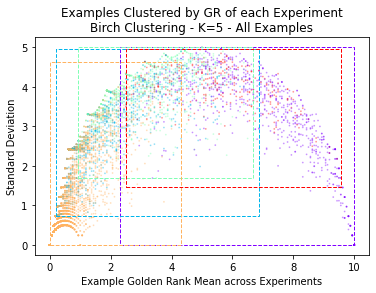

In [65]:
X = grls_np.T
X_means = grs_means
X_std = grs_std
maxBins = maxBins
K_clusters = 5

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="All Examples", 
    save_path = Path("../assets/").joinpath("cluster5_all") )
with open('../assets/cluster5_all.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))

print(counts_pd.to_string(index=False))


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    4654     0.0000   0.0000 0.000000 0.000000
  Mostly Correct    4392     0.0000   4.3125 0.000000 4.635124
       Uncertain     876     0.1875   6.8750 0.726184 4.960784
       Uncertain     892     0.9375   6.6875 1.695582 5.000000
       Uncertain    1059     2.3125  10.0000 0.000000 5.000000
       All Wrong       0     0.0000   0.0000 0.000000 0.000000


/home/farsipal/projects/GITHUB/GR-GRIM/notebooks/utils_anal.py:441: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_38670/2512283885.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(counts_pd.to_latex(index=False))


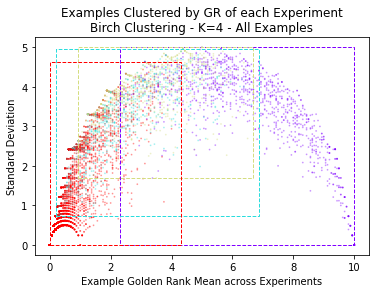

In [66]:
X = grls_np.T
X_means = grs_means
X_std = grs_std
maxBins = maxBins
K_clusters = 4

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="All Examples", 
    save_path = Path("../assets/").joinpath("cluster4_all") )
with open('../assets/cluster4_all.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    2538     0.0000   0.0000 0.000000 0.000000
  Mostly Correct    2420     0.0000   6.4375 0.000000 4.943035
       Uncertain     583     1.1875   8.8750 2.185714 5.000000
       Uncertain     404     3.5000  10.0000 0.000000 4.833154
       All Wrong       0     0.0000   0.0000 0.000000 0.000000


/home/farsipal/projects/GITHUB/GR-GRIM/notebooks/utils_anal.py:441: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_38670/2383175134.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(counts_pd.to_latex(index=False))


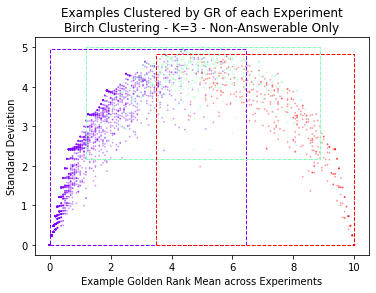

In [67]:
X = grs_na.T
X_means = grs_na_means
X_std = grs_na_std
maxBins = maxBins
K_clusters = 3

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Non-Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster3_na") )
with open('../assets/cluster3_na.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    2116       0.00   0.0000  0.00000 0.000000
  Mostly Correct    2715       0.00   4.6875  0.00000 4.485654
       Uncertain     541       0.25   5.7500  0.75000 4.639757
       Uncertain     422       1.75   8.1875  1.63936 4.911323
       Uncertain     134       6.25  10.0000  0.00000 4.547922
       All Wrong       0       0.00   0.0000  0.00000 0.000000


/home/farsipal/projects/GITHUB/GR-GRIM/notebooks/utils_anal.py:441: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_38670/212786807.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(counts_pd.to_latex(index=False))


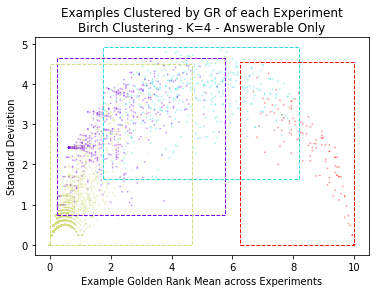

In [68]:
X = grs_ans.T
X_means = grs_ans_means
X_std = grs_ans_std
maxBins = maxBins
K_clusters = 4

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster4_ans") )
with open('../assets/cluster4_ans.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    2116       0.00   0.0000     0.00 0.000000
  Mostly Correct    2715       0.00   4.6875     0.00 4.485654
       Uncertain     541       0.25   5.7500     0.75 4.639757
       Uncertain     556       1.75  10.0000     0.00 4.911323
       All Wrong       0       0.00   0.0000     0.00 0.000000


/home/farsipal/projects/GITHUB/GR-GRIM/notebooks/utils_anal.py:441: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_38670/364899737.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  F.write(counts_pd.to_latex(index=False))


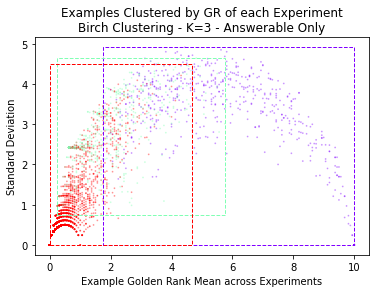

In [69]:
X = grs_ans.T
X_means = grs_ans_means
X_std = grs_ans_std
maxBins = maxBins
K_clusters = 3

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster3_ans") )
with open('../assets/cluster3_ans.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))



## Golden Rank (GR)

The Golden Rank $R$ is the lowest rank in the order of descenting probability of the prediction exactly matching one of the golden answers. 

The output layer of the model yields a vector of start logits and end logits for each example.  These are then passed through masked softmax producing two probability vectors, one for the start marker and another for the end marker. 

The two probability vectors for each example are then combined to form a single probability which is the value provided in the top-N results. The choice of the function that combines the two probabilities to produce the combined probability in the Huggingface implementation is a simple average of the start and end probability. There are other possibilities however:

*   The product of the two probabilities can be used instead of the average (used in the BiDAF starter code) 
*   Taking a weighted average is discussed in various articles, for example in [*Question and Answering on SQuAD 2.0: BERT Is All You Need* by Schwager and Solitario](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf). They argue that the start probability carries more weight than the end probability so weighing the start twice as much as the end may be appropriate.
*  Hyperparameter settings favoring no-answer detection have weaker scores in F1 and exact match detection, and vice versa. This observation was made by the same paper above, and we confirmed it through our own experimentation. 

We now calculate the Golden Rank from the predictions in RS. 

The value maxBins is used to size the histograms to the ranks available in the data.
The topNPreds returns a list of dictionaries, one for each experiment. 
Each of these, are indexed by example ID, and they contain the list of ranked predictions for it. 
We walk down that list and rank the id with the rank of the first correct answer we encounter. If the list goes past the maxBins, the last bin contains the rank that captures the result. If no entry exists with a correct answer, then the default rank will be used.

In [70]:
grls_np, nas_np, maxBinsActual, mediansNonZeroRanks_np, grls = RS.calc_golden_ranks(maxBins = 10)
len(grls[10])

11873

## Mean rank

Smaller is better

In [71]:
np.mean(grls_np,axis=1)



array([1.62840057, 1.451276  , 1.2985766 , 1.24854712, 0.88200118,
       0.81310537, 1.06426345, 0.97186895, 1.13442264, 1.0146551 ,
       1.1908532 , 0.97287964, 0.8026615 , 1.63134844, 1.76130717,
       1.7447149 ])

## Median Rank

In [72]:
[np.median([r  for r in L if r>0]) for L in grls]

[5.0,
 4.0,
 3.0,
 3.0,
 3.0,
 2.0,
 4.0,
 3.0,
 4.0,
 3.0,
 4.0,
 3.0,
 2.0,
 3.0,
 4.0,
 4.0]

## Interpolated Median Rank

In [73]:
[median_grouped([r  for r in L if r>0]) for L in grls]


[5.3396946564885495,
 4.383620689655173,
 2.909090909090909,
 2.7009345794392523,
 2.7260273972602738,
 2.3793650793650793,
 3.65,
 3.125766871165644,
 3.84375,
 3.3986013986013988,
 4.378787878787879,
 3.1099290780141846,
 2.2329376854599405,
 3.4051383399209487,
 3.966824644549763,
 3.994949494949495]

## Scaterplots of Interpolated Median and Mean

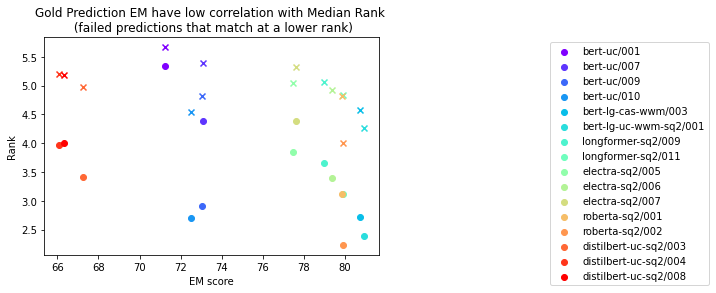

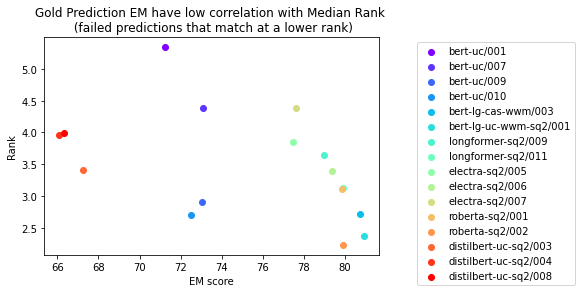

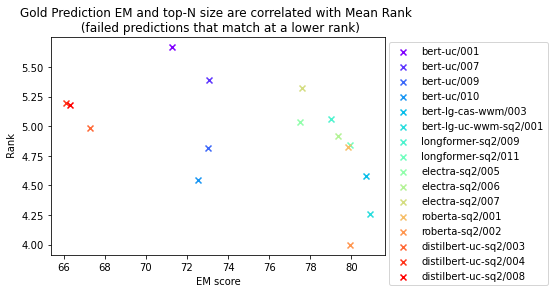

,EM,Median,Mean,labels
0,28.737472,5.339695,5.666471,bert-uc/001
1,26.909795,4.383621,5.393114,bert-uc/007
2,26.968753,2.909091,4.815116,bert-uc/009
3,27.474101,2.700935,4.544451,bert-uc/010
4,19.270614,2.726027,4.576923,bert-lg-cas-wwm/003
5,19.085320,2.379365,4.260371,bert-lg-uc-wwm-sq2/001
6,21.014066,3.650000,5.064529,longformer-sq2/009
7,20.079171,3.125767,4.840185,longformer-sq2/011
8,22.521688,3.843750,5.037023,electra-sq2/005
9,20.643477,3.398601,4.915137,electra-sq2/006


In [74]:
grls = grls #RS.topNPreds(topK=10)
R = []
md = []
mn = []
df = []
score = []
for L in grls:
    M = len(L)
    R = [r for r in L if r > 0]
    #md.append(median_grouped(R))
    #mn.append(np.mean(R))
    #score.append(np.array(R).shape[0]/M*100)
    df.append([np.array(R).shape[0]/M*100,median_grouped(R),np.mean(R)])
#md = np.array(md)
#mn = np.array(mn)
#score = np.array(score)
df = pd.DataFrame(df)
df.columns = ['EM','Median','Mean']
df['labels'] = RS.labels


#plt.scatter(score,md)
#plt.legend(labels=RS.experiments,loc='upper right', bbox_to_anchor=(2, 1))
#plt.title("Gold Pred Rank vs median\n of failed predictions")
#plt.show()

#plt.scatter(score,mn)
#plt.legend(labels=RS.experiments,loc='upper right', bbox_to_anchor=(2, 1))
#plt.title("Gold Pred Rank vs mean\n of failed predictions")
#plt.show()

colors = cm.rainbow(np.linspace(0, 1, len(df)))

#plt.scatter(df.EM,df.Mean,color=colors)
#plt.title("Gold Pred Rank vs median and mean\n of failed predictions")
#plt.legend(labels=df.experiment,loc='upper right', bbox_to_anchor=(2, 1))
#plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y1, marker='o', color=c)
plt.title("Gold Prediction EM have low correlation with Median Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(2, 1))
plt.xlabel("EM score")
plt.ylabel("Rank")
for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y2, marker='x', color=c)

plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y1, marker='o', color=c)
plt.title("Gold Prediction EM have low correlation with Median Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(1.6, 1))
plt.xlabel("EM score")
plt.ylabel("Rank")
plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y2, marker='x', color=c)
plt.title("Gold Prediction EM and top-N size are correlated with Mean Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(1.5, 1))
plt.xlabel("EM score")
plt.ylabel(" Rank")
plt.show()

df